# Plot VIIRS 

This example code plots some VIIRS data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
#import netCDF4
#import h5netcdf

def explore_vj202_structure(filename):
    """
    Explore the VJ202IMG NetCDF file structure using xarray
    """
    print("VJ202IMG NetCDF File Structure:")
    print("=" * 60)
    
    # Open the dataset
    ds = xr.open_dataset(filename, group='/')
    
    print("\nRoot level info:")
    print(f"Dimensions: {dict(ds.dims)}")
    print(f"Variables: {list(ds.data_vars)}")
    print(f"Coordinates: {list(ds.coords)}")
    
    # Try to access groups
    try:
        # Check for observation_data group
        obs_ds = xr.open_dataset(filename, group='observation_data')
        print("\nobservation_data group variables:")
        print(list(obs_ds.data_vars))
        obs_ds.close()
    except Exception as e:
        print(f"\nCouldn't access observation_data group: {e}")
    
    ds.close()

def read_vj202_band(filename, band_num, geo_filename=None):
    """
    Read a single I-band from VJ202IMG NetCDF file using xarray
    
    Parameters:
    -----------
    filename : str
        Path to VJ202IMG NetCDF file
    band_num : int
        Band number (1-5)
    geo_filename : str, optional
        Path to VJ203IMG geolocation file (REQUIRED for proper mapping)
    
    Returns:
    --------
    data : xarray.DataArray
        Band data with metadata
    lat : np.ndarray
        Latitude array
    lon : np.ndarray
        Longitude array
    """
    
    # Open observation_data group
    ds = xr.open_dataset(filename, group='observation_data')
    
    # Band variable name (I01, I02, etc.)
    band_var = f'I{band_num:02d}'
    
    if band_var not in ds.data_vars:
        print(f"Available variables: {list(ds.data_vars)}")
        ds.close()
        return None, None, None
    
    # Read data - xarray automatically handles scale_factor and add_offset
    data = ds[band_var]
    
    # Mask fill values - xarray handles this automatically with decode_cf=True (default)
    # But we can explicitly mask invalid values
    data = data.where(data != data.attrs.get('_FillValue', np.nan))
    
    # Convert to numpy array (masked)
    data_array = data.values
    data_array = np.ma.masked_invalid(data_array)
    
    ds.close()
    
    # Read geolocation from VJ203IMG file
    if geo_filename:
        try:
            # Try geolocation_data group first
            geo_ds = xr.open_dataset(geo_filename, group='geolocation_data')
            lat = geo_ds['latitude'].values
            lon = geo_ds['longitude'].values
            geo_ds.close()
        except Exception as e:
            # Try root level
            try:
                geo_ds = xr.open_dataset(geo_filename)
                if 'latitude' in geo_ds.data_vars:
                    lat = geo_ds['latitude'].values
                    lon = geo_ds['longitude'].values
                else:
                    print(f"Cannot find lat/lon in VJ203IMG file: {e}")
                    print(f"Available variables: {list(geo_ds.data_vars)}")
                    lat = np.arange(data_array.shape[0])
                    lon = np.arange(data_array.shape[1])
                geo_ds.close()
            except Exception as e2:
                print(f"Error reading geolocation file: {e2}")
                lat = np.arange(data_array.shape[0])
                lon = np.arange(data_array.shape[1])
    else:
        print("WARNING: No geolocation file provided!")
        print("VJ202IMG does NOT contain lat/lon data.")
        print("Download VJ203IMG file for proper geographic mapping.")
        print("Creating dummy pixel coordinates for now...")
        lat = np.arange(data_array.shape[0])
        lon = np.arange(data_array.shape[1])
    
    return data_array, lat, lon

def plot_vj202_band(filename, band_num=2, geo_filename=None):
    """
    Plot VIIRS I-band from VJ202IMG NetCDF file
    
    Parameters:
    -----------
    filename : str
        Path to VJ202IMG NetCDF file
    band_num : int
        I-band number (1-5)
        I01: 640nm (Red)
        I02: 865nm (NIR)
        I03: 1610nm (SWIR)
        I04: 3740nm (MWIR)
        I05: 11450nm (LWIR)
    geo_filename : str, optional
        Path to VJ203IMG geolocation file
    
    Returns:
    --------
    fig, ax : matplotlib figure and axis objects
    """
    
    data, lat, lon = read_vj202_band(filename, band_num, geo_filename)
    
    if data is None:
        return None, None
    
    # Create figure
    fig = plt.figure(figsize=(14, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    # Plot the data
    im = ax.pcolormesh(lon, lat, data, 
                       transform=ccrs.PlateCarree(),
                       cmap='gray', shading='auto')
    
    # Add map features
    ax.coastlines(resolution='50m', color='red', linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.STATES, linewidth=0.3, edgecolor='gray')
    ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False,
                 linewidth=0.5, alpha=0.5)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', 
                       pad=0.02, shrink=0.7)
    cbar.set_label(f'Radiance (W/m²/sr/μm)', rotation=270, labelpad=20)
    
    # Band names
    band_names = {
        1: 'I01 (640nm - Red)',
        2: 'I02 (865nm - NIR)',
        3: 'I03 (1610nm - SWIR)',
        4: 'I04 (3740nm - MWIR)',
        5: 'I05 (11450nm - LWIR)'
    }
    
    plt.title(f'NOAA-21 VIIRS {band_names[band_num]} - 375m Resolution', 
              fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    
    return fig, ax

def plot_enhanced_contrast(filename, band_num=2, geo_filename=None):
    """
    Plot with enhanced contrast using percentile stretching
    
    Returns:
    --------
    fig, ax : matplotlib figure and axis objects
    """
    
    data, lat, lon = read_vj202_band(filename, band_num, geo_filename)
    
    if data is None:
        return None, None
    
    # Enhanced contrast
    valid_data = data.compressed() if np.ma.is_masked(data) else data[~np.isnan(data)]
    vmin = np.percentile(valid_data, 10)
    vmax = np.percentile(valid_data, 40)
    
    # Create figure
    fig = plt.figure(figsize=(14, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    im = ax.pcolormesh(lon, lat, data, 
                       transform=ccrs.PlateCarree(),
                       cmap='gray', shading='auto',
                       vmin=vmin, vmax=vmax)
    
    ax.coastlines(resolution='50m', color='cyan', linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='cyan')
    ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)
    
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.02, shrink=0.7)
    cbar.set_label(f'Radiance (Enhanced)', rotation=270, labelpad=20)
    
    band_names = {1: 'Red', 2: 'NIR', 3: 'SWIR', 4: 'MWIR', 5: 'LWIR'}
    plt.title(f'NOAA-21 VIIRS I{band_num:02d} ({band_names[band_num]}) - Enhanced Contrast', 
              fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    
    return fig, ax

def plot_false_color_nir(filename, geo_filename=None):
    """
    Create false color composite: NIR-Red-Green
    Vegetation appears red/pink
    
    Parameters:
    -----------
    filename : str
        Path to VJ202IMG NetCDF file (contains all I-bands)
    geo_filename : str, optional
        Path to VJ203IMG geolocation file
    
    Returns:
    --------
    fig, ax : matplotlib figure and axis objects
    """
    
    # Read bands
    nir, lat, lon = read_vj202_band(filename, 2, geo_filename)   # I02 - NIR
    red, _, _ = read_vj202_band(filename, 1, geo_filename)       # I01 - Red
    
    # For green, approximate with red scaled down
    green = red * 0.7
    
    if nir is None or red is None:
        return None, None
    
    # Stack into RGB
    rgb = np.dstack([nir, red, green])
    
    # Normalize each channel to 0-1
    for i in range(3):
        band = rgb[:,:,i]
        if np.ma.is_masked(band):
            valid = band.compressed()
        else:
            valid = band[~np.isnan(band)]
        
        if len(valid) > 0:
            p2, p98 = np.percentile(valid, [2, 98])
            rgb[:,:,i] = np.clip((band - p2) / (p98 - p2), 0, 1)
    
    # Handle masked values
    if np.ma.is_masked(nir):
        rgb = np.ma.filled(rgb, 0)
    
    # Plot
    fig = plt.figure(figsize=(14, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    extent = [lon.min(), lon.max(), lat.min(), lat.max()]
    ax.imshow(rgb, origin='upper', extent=extent, 
              transform=ccrs.PlateCarree())
    
    ax.coastlines(resolution='50m', color='yellow', linewidth=1)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='yellow')
    ax.gridlines(draw_labels=True, color='white', alpha=0.5)
    
    plt.title('NOAA-21 VIIRS False Color (NIR-Red-Red*0.7)\nVegetation in Red/Pink', 
              fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    return fig, ax

def plot_side_by_side(filename, geo_filename=None):
    """
    Plot I01 (Red) and I02 (NIR) side by side for comparison
    
    Returns:
    --------
    fig, (ax1, ax2) : matplotlib figure and axis objects
    """
    
    red, lat, lon = read_vj202_band(filename, 1, geo_filename)
    nir, _, _ = read_vj202_band(filename, 2, geo_filename)
    
    if red is None or nir is None:
        return None, None
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8),
                                    subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Plot Red
    im1 = ax1.pcolormesh(lon, lat, red, 
                         transform=ccrs.PlateCarree(),
                         cmap='Reds', shading='auto')
    ax1.coastlines(resolution='50m', color='black', linewidth=0.8)
    ax1.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax1.gridlines(draw_labels=True)
    ax1.set_title('I01 - Red (640nm)', fontsize=12, fontweight='bold')
    plt.colorbar(im1, ax=ax1, orientation='vertical', pad=0.02, shrink=0.7)
    
    # Plot NIR
    im2 = ax2.pcolormesh(lon, lat, nir, 
                         transform=ccrs.PlateCarree(),
                         cmap='YlOrRd', shading='auto')
    ax2.coastlines(resolution='50m', color='black', linewidth=0.8)
    ax2.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax2.gridlines(draw_labels=True)
    ax2.set_title('I02 - NIR (865nm)', fontsize=12, fontweight='bold')
    plt.colorbar(im2, ax=ax2, orientation='vertical', pad=0.02, shrink=0.7)
    
    plt.suptitle('NOAA-21 VIIRS Red vs NIR Comparison', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    return fig, (ax1, ax2)

def quick_plot_simple(filename, band_num=2):
    """
    Simple plot without cartopy - useful for quick checks
    
    Returns:
    --------
    fig, ax : matplotlib figure and axis objects
    """
    
    data, _, _ = read_vj202_band(filename, band_num)
    
    if data is None:
        return None, None
    
    fig, ax = plt.subplots(figsize=(12, 8))
    im = ax.imshow(data, cmap='gray', aspect='auto')
    plt.colorbar(im, ax=ax, label='Radiance')
    ax.set_title(f'NOAA-21 VIIRS I{band_num:02d}')
    ax.set_xlabel('Pixel X')
    ax.set_ylabel('Pixel Y')
    plt.tight_layout()
    
    return fig, ax

def check_resolution(filename, geo_filename=None):
    """
    Check the actual spatial resolution of the VIIRS data using xarray
    """
    print("Checking VIIRS data resolution:")
    print("=" * 60)
    
    # Open observation data
    ds = xr.open_dataset(filename, group='observation_data')
    data_shape = ds['I01'].shape
    print(f"Data array shape: {data_shape}")
    print(f"  Along-track: {data_shape[0]} pixels")
    print(f"  Cross-track: {data_shape[1]} pixels")
    ds.close()
    
    if geo_filename:
        try:
            # Try geolocation_data group
            geo_ds = xr.open_dataset(geo_filename, group='geolocation_data')
            lat = geo_ds['latitude'].values
            lon = geo_ds['longitude'].values
            geo_shape = lat.shape
            
            print(f"\nGeolocation array shape: {geo_shape}")
            
            # Calculate approximate pixel size in center of swath
            mid_row = geo_shape[0] // 2
            mid_col = geo_shape[1] // 2
            
            # Lat difference (vertical)
            dlat = abs(lat[mid_row+1, mid_col] - lat[mid_row, mid_col])
            # Lon difference (horizontal) 
            dlon = abs(lon[mid_row, mid_col+1] - lon[mid_row, mid_col])
            
            # Convert to meters (rough approximation)
            lat_meters = dlat * 111320  # 1 degree lat ≈ 111.32 km
            lon_meters = dlon * 111320 * np.cos(np.radians(lat[mid_row, mid_col]))
            
            print(f"\nApproximate pixel size at nadir (center of swath):")
            print(f"  Along-track: {lat_meters:.1f} meters")
            print(f"  Cross-track: {lon_meters:.1f} meters")
            
            if data_shape != geo_shape:
                print(f"\n⚠️  WARNING: Data shape {data_shape} != Geolocation shape {geo_shape}")
                print(f"  This indicates the data may be aggregated or at different resolution")
            
            geo_ds.close()
            
        except Exception as e:
            print(f"\nError reading geolocation file: {e}")
            print("Provide correct VJ203IMG file to calculate actual pixel resolution")
    else:
        print("\nProvide VJ203IMG file to calculate actual pixel resolution")
    
    print("\nExpected VIIRS I-band resolution:")
    print("  At nadir (center): ~375 meters")
    print("  At swath edge: ~750 meters")


def load_full_dataset(filename, geo_filename=None):
    """
    Load all bands as a combined xarray Dataset with geolocation
    This is a bonus function showing xarray's power for multi-band analysis
    
    Parameters:
    -----------
    filename : str
        Path to VJ202IMG NetCDF file
    geo_filename : str, optional
        Path to VJ203IMG geolocation file
    
    Returns:
    --------
    ds : xarray.Dataset
        Combined dataset with all bands and geolocation
    """
    
    # Load all bands
    ds = xr.open_dataset(filename, group='observation_data')
    
    # Load geolocation if provided
    if geo_filename:
        try:
            geo_ds = xr.open_dataset(geo_filename, group='geolocation_data')
            # Add lat/lon as coordinates
            ds = ds.assign_coords({
                'latitude': (['y', 'x'], geo_ds['latitude'].values),
                'longitude': (['y', 'x'], geo_ds['longitude'].values)
            })
            geo_ds.close()
        except Exception as e:
            print(f"Could not load geolocation: {e}")
    
    return ds


# Example usage
if __name__ == "__main__":
    # Your VJ202IMG NetCDF file
    vj202_file = r"C:\Users\no\Documents\School\2025-2026 school\Spring 2026\AES 408 - Python for GIS\Repository\hw1\VJ202IMG.A2025197.1600.021.2025197223032.nc"
    vj203_file = r"C:\Users\no\Documents\School\2025-2026 school\Spring 2026\AES 408 - Python for GIS\Repository\hw1\VJ203IMG.A2025197.1600.021.2025197221722.nc"  # Optional geolocation file
    
    # Explore file structure first
    #explore_vj202_structure(vj202_file)
    
    # Plot NIR band (I02) - returns fig, ax for further manipulation
    # fig, ax = plot_vj202_band(vj202_file, band_num=2, geo_filename=vj203_file)
    # ax.set_xlim(-100, -80)  # Zoom to specific longitude range
    # ax.set_ylim(25, 45)     # Zoom to specific latitude range
    # plt.show()
    
    # Plot Red band (I01)
    # fig, ax = plot_vj202_band(vj202_file, band_num=1, geo_filename=vj203_file)
    # plt.show()
    
    # Enhanced contrast version
    # fig, ax = plot_enhanced_contrast(vj202_file, band_num=2, geo_filename=vj203_file)
    # plt.show()
    
    # False color composite (vegetation in red)
    # fig, ax = plot_false_color_nir(vj202_file, geo_filename=vj203_file)
    # plt.show()
    
    # Side by side comparison
    # fig, (ax1, ax2) = plot_side_by_side(vj202_file, geo_filename=vj203_file)
    # for ax in [ax1, ax2]:
    #     ax.set_xlim(-100, -80)
    #     ax.set_ylim(25, 45)
    # plt.show()
    
    # Quick simple plot (no geolocation needed)
    # fig, ax = quick_plot_simple(vj202_file, band_num=2)
    # plt.show()
    
    # Load full dataset with xarray (bonus feature)
    # ds = load_full_dataset(vj202_file, geo_filename=vj203_file)
    # print(ds)  # Shows all bands and metadata
    # ds.close()
    
    #print("Update file paths and uncomment functions to use")
    #print("Note: VJ203IMG file is optional but recommended for accurate geolocation")


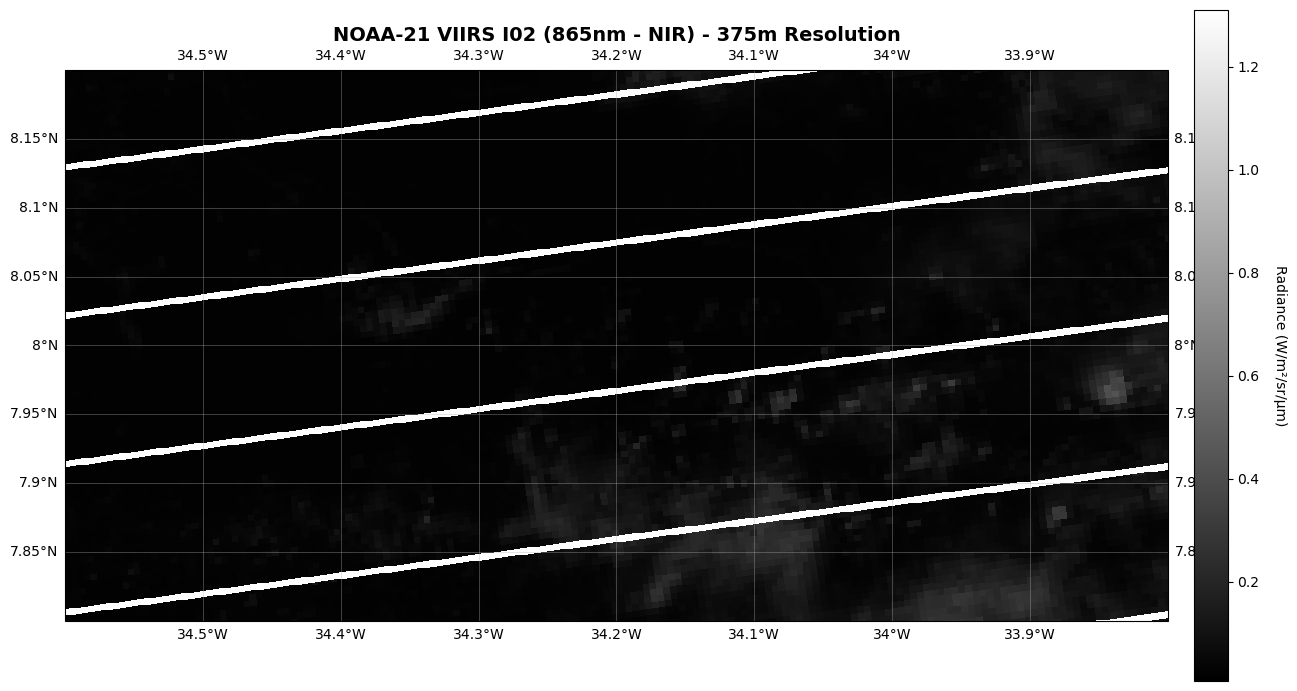

In [5]:
fig, ax = plot_vj202_band(r"C:\Users\no\Documents\School\2025-2026 school\Spring 2026\AES 408 - Python for GIS\Repository\hw1\VJ202IMG.A2025197.1600.021.2025197223032.nc",
                            geo_filename=r'C:\Users\no\Documents\School\2025-2026 school\Spring 2026\AES 408 - Python for GIS\Repository\hw1\VJ203IMG.A2025197.1600.021.2025197221722.nc')
ax.set_extent([-34.6, -33.8, 7.8,8.2])

c:\Users\no\Documents\School\2025-2026 school\Spring 2026\AES 408 - Python for GIS\Repository\hw1\.pixi\envs\default\Lib\site-packages\numpy\lib\_function_base_impl.py:4786: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


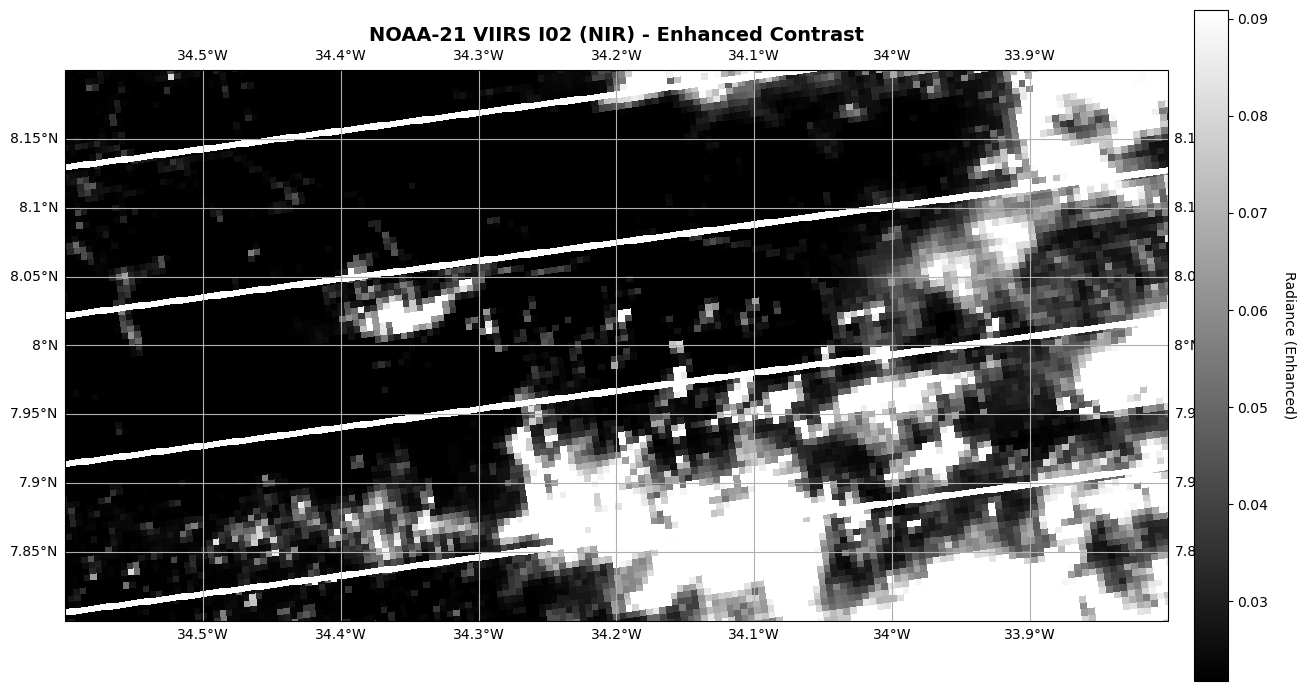

In [4]:
fig, ax = plot_enhanced_contrast(r"C:\Users\no\Documents\School\2025-2026 school\Spring 2026\AES 408 - Python for GIS\Repository\hw1\VJ202IMG.A2025197.1600.021.2025197223032.nc",
                            geo_filename=r'C:\Users\no\Documents\School\2025-2026 school\Spring 2026\AES 408 - Python for GIS\Repository\hw1\VJ203IMG.A2025197.1600.021.2025197221722.nc')
ax.set_extent([-34.6, -33.8, 7.8,8.2])
plt.savefig("viirs_noaa21_sargassum.png")

In [ ]:
2